In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
ENTER_POINT = os.getcwd()
ENTER_POINT = ENTER_POINT[:ENTER_POINT.rfind('/')]
sys.path.append(ENTER_POINT)

In [2]:
# Packages
import json
import logging
import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt

# File imports
from configs import config as cfg
import helper_functions.helper_functions as hf
from preprocess_data.preprocess import drop_columns, calculate_vif
from utils.adstock_functions import adstock_transform, geometric_adstock
from saturation.saturation import saturation_hill_pymc3, apply_saturation
from control_model.control import (idx_col_list, max_intercept_func, build_ctrl_model, fit_ctrl_model,
                                   retrieve_ctrl_samples, get_ctrl_contrib_df, get_beta_ctrl_df)
from media_model.sampling import fit_model
from media_model.media_betas import (get_adstk_sat_df, get_spend_df, get_roi_spend_df_full, get_betas_dict,
                                     get_reloop_model, get_media_parameters, get_beta_media_model)
from media_model.media import MediaModelBis
from media_model.extract_results import (rebuild_mc_df, get_output_roi_df, get_non_media_contribution,
                                         get_final_contribution_output, sanity_check, rebuild_factor_df)
from saturation.saturation import SaturationCurves, show_saturation, get_saturation_model_params
from preprocess_data import rebuild_results
from media_model import restore_results

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Set up

In [3]:
uploaded_file = cfg.PATH_INPUT_DATA
data = pd.read_csv(uploaded_file, parse_dates=[cfg.DT], index_col=cfg.DT)

uploaded_file2 = cfg.PATH_AVG_PRICE
get_avg_price_df = pd.read_csv(uploaded_file2, parse_dates=[cfg.DT], index_col=cfg.DT, usecols=[cfg.DT, 'avg_price'])

logging.info('All input data uploaded, Staring with data pre-processing!')

data = drop_columns(data, cfg.TO_DROP)
VIF_df = calculate_vif(data, cfg.POS_VARS + cfg.PN_VARS)
df_ctrl, sc_ctrl = hf.mean_center_transform(data, cfg.POS_VARS + cfg.PN_VARS + [cfg.TGT])

df_ctrl.to_csv(os.path.join(cfg.DATA_PATH, cfg.INTER_PATH, 'df_ctrl.csv'))
VIF_df.to_csv(os.path.join(cfg.DATA_PATH, cfg.INTER_PATH, 'vif_df.csv'))
json.dump(sc_ctrl, open(os.path.join(cfg.DATA_PATH, cfg.INTER_PATH, 'sc_ctrl.json'), 'w'))

# upload_to_bucket(GCP_ID + '/intermediate_files/df_ctrl.csv', getcwd() + INTER_PATH + 'df_ctrl.csv', bucket_name)
# upload_to_bucket(GCP_ID + '/intermediate_files/vif_df.csv', getcwd() + INTER_PATH + 'vif_df.csv', bucket_name)
# upload_to_bucket(GCP_ID + '/intermediate_files/sc_ctrl.json', getcwd() + INTER_PATH + 'sc_ctrl.json', bucket_name)

# Control model

In [4]:
%%time
logging.info('Data pre-processing done, Staring Control Model!')

IDX_COL = idx_col_list(df_ctrl)
MAX_INTERCEPT = max_intercept_func(df_ctrl)
ctrl_model = build_ctrl_model(df_ctrl, IDX_COL, cfg.TIMEVARYING_VARS_LAGS, MAX_INTERCEPT)  # build control model
trace_control, summary_control = fit_ctrl_model(ctrl_model)
post_pred_control = retrieve_ctrl_samples(ctrl_model, trace_control)
contrib_df = get_ctrl_contrib_df(df_ctrl, sc_ctrl, post_pred_control)

Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, alpha, beta_tdp, beta_comp_tdp, beta_price, beta_covid_start, beta_covid, beta_dfsi, beta_fsi, beta__last__yearly-monthly-hldy_hol, beta__first__yearly-monthly-hldy_hol, beta__last__promo_acv, beta__first__promo_acv]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 183 seconds.
There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 296 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 176 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


CPU times: user 1min 24s, sys: 1 s, total: 1min 25s
Wall time: 4min 22s


In [5]:
hf.pickle_dump(os.path.join(cfg.DATA_PATH, cfg.MODEL_DUMP_PATH), 'ctrl_model.pickle', ctrl_model)
summary_control.to_csv(os.path.join(cfg.DATA_PATH, cfg.INTER_PATH, 'summary_control.csv'))
hf.json_dump(os.path.join(cfg.DATA_PATH, cfg.INTER_PATH), 'post_pred_control.json', post_pred_control)
contrib_df.to_csv(os.path.join(cfg.DATA_PATH, cfg.INTER_PATH, 'contrib_df.csv'))

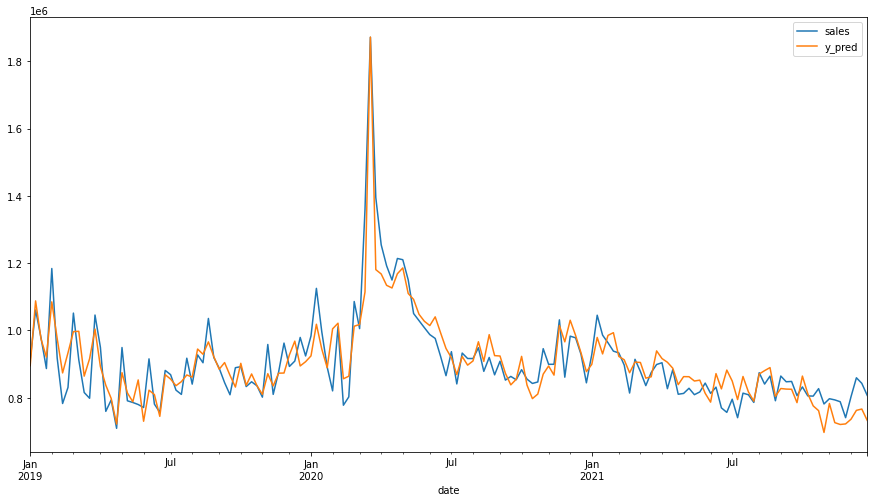

In [6]:
hf.show_prediction(contrib_df, os.path.join(cfg.DATA_PATH, cfg.IMAGE_DUMP_PATH, 'control_prediction.png'), 
                   col_true='sales', col_pred='y_pred')

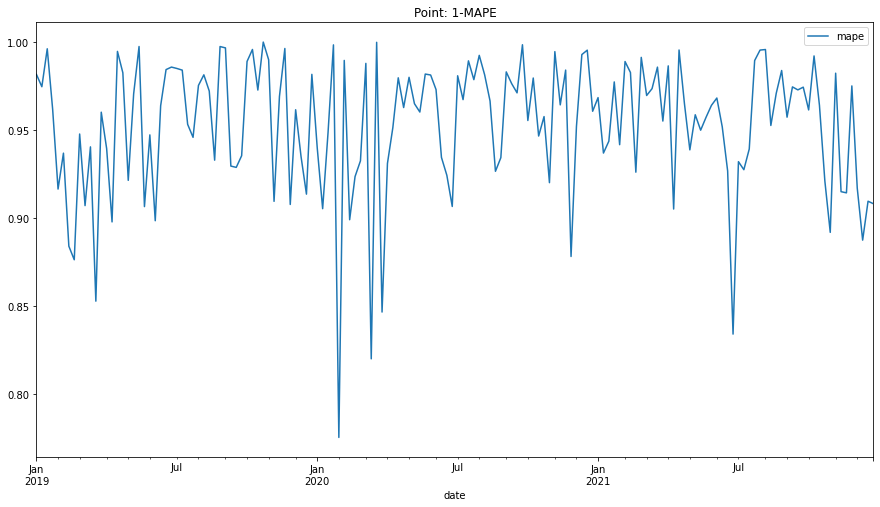

In [7]:
hf.show_mape(contrib_df, os.path.join(cfg.DATA_PATH, cfg.IMAGE_DUMP_PATH, 'control_mape.png'),
             col_true='sales', col_pred='y_pred')

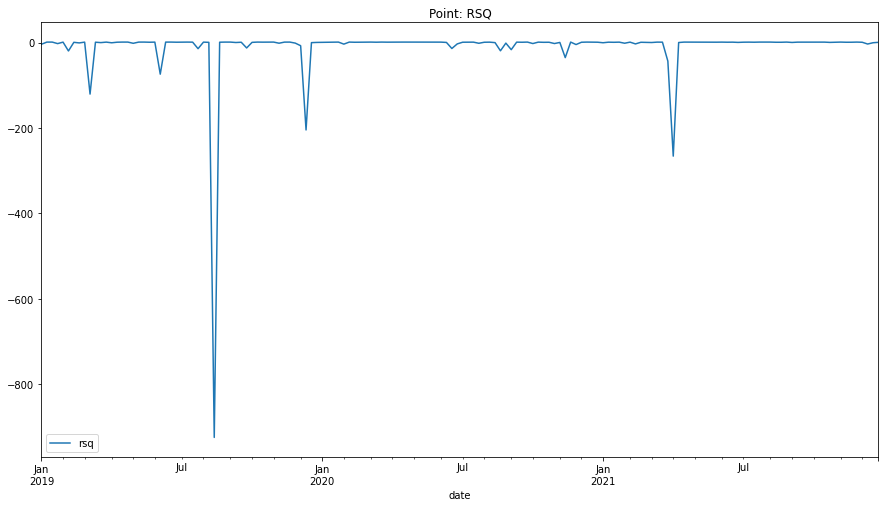

In [8]:
hf.show_rsq(contrib_df, os.path.join(cfg.DATA_PATH, cfg.IMAGE_DUMP_PATH, 'control_rsq.png'), 
            col_true='sales', col_pred='y_pred')

# Media model

In [9]:
logging.info('Control model done, Staring Media Model!')

ctrl_model.df = data
ctrl_model.tgt = cfg.TGT
ctrl_model.df_ctrl, ctrl_model.sc_ctrl = df_ctrl, sc_ctrl
ctrl_model.b_tgt = cfg.B_TGT  # Unscaled ctrl model predictions are full model baseline sales
ctrl_model.df[ctrl_model.b_tgt] = contrib_df[['y_pred']]

In [10]:
%%time
media_model = MediaModelBis(ctrl_model, ['online_sales'])

# Check if the totals match: media and baseline sales are supposed to cover 100% of actual sales
check = (media_model.mc_df[media_model.mdip_cols + [media_model.bsl]].sum(axis=1).sum() == media_model.mc_df[
    cfg.TGT].sum())
print("Media + Baseline = Sales --> {}".format(check))

sales
base_sales
online_sales
               sales  base_sales  online_sales
date                                          
2019-01-05  0.697307    0.687823      0.057360
2019-01-12  0.775820    0.789370      0.106738
2019-01-19  0.733127    0.730927      0.141618
2019-01-26  0.683126    0.701806      0.106547
2019-02-02  0.836682    0.787942      0.248094
...              ...         ...           ...
2021-11-27  0.598124    0.586656      0.782240
2021-12-04  0.635162    0.595169      0.804851
2021-12-11  0.667703    0.611120      0.782279
2021-12-18  0.658269    0.613478      0.756247
2021-12-25  0.637635    0.593158      0.744142

[156 rows x 3 columns]


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [gamma, alpha, beta_comp, beta, decay, peak, noise_var, tau]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 627 seconds.
There were 2460 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2472 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2466 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2471 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2477 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.47086351595578235, but should be close to 0.9. Try to increase the number of tuning steps.
There were 2447 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2486 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The

/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/hakon/.local/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pym

media 24
ctrl 2
betas 26
Media + Baseline = Sales --> True
CPU times: user 4min 11s, sys: 1.91 s, total: 4min 13s
Wall time: 14min 29s


/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [11]:
media_model.fit_summary.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[23],0.494,0.214,0.072,0.855,0.014,0.010,320.0,1359.0,1.03
alpha[1],3.085,1.497,1.000,5.740,0.053,0.037,357.0,1497.0,1.03
alpha[17],2.701,1.738,0.109,5.614,0.080,0.056,321.0,1024.0,1.03
gamma[13],0.471,0.207,0.138,0.891,0.016,0.014,347.0,595.0,1.03
peak[5],0.996,0.096,0.803,1.176,0.004,0.003,532.0,991.0,1.03
...,...,...,...,...,...,...,...,...,...
decay[22],0.435,0.219,0.084,0.785,0.045,0.032,23.0,20.0,1.28
decay[4],0.537,0.226,0.193,0.922,0.050,0.042,21.0,26.0,1.29
alpha[7],3.511,2.448,0.616,8.725,0.674,0.544,21.0,26.0,1.29
beta[17],0.229,0.417,0.000,1.308,0.144,0.108,20.0,14.0,1.34


In [12]:
df_media_params = get_media_parameters(media_model)
df_media_params.to_csv(cfg.PATH_MEDIA_MODEL_PARAMS)
df_media_params

,max_lag,peak,decay,alpha,gamma
media_vars,,,,,
amb,4,1.519496,0.526594,3.249042,0.542208
amzdsp,4,0.499996,0.524261,2.893118,0.516415
amzsearch,4,-0.035715,0.459831,2.700990,0.359826
cin,4,1.003670,0.508181,3.262448,0.494335
ctv,4,1.505122,0.495919,2.950486,0.486985
fb,4,1.979114,0.519285,2.900793,0.471906
fep,4,1.490888,0.459922,3.073189,0.517534
fluency,4,1.020630,0.435101,2.975442,0.492119
gads,4,0.481362,0.481559,3.231766,0.444775


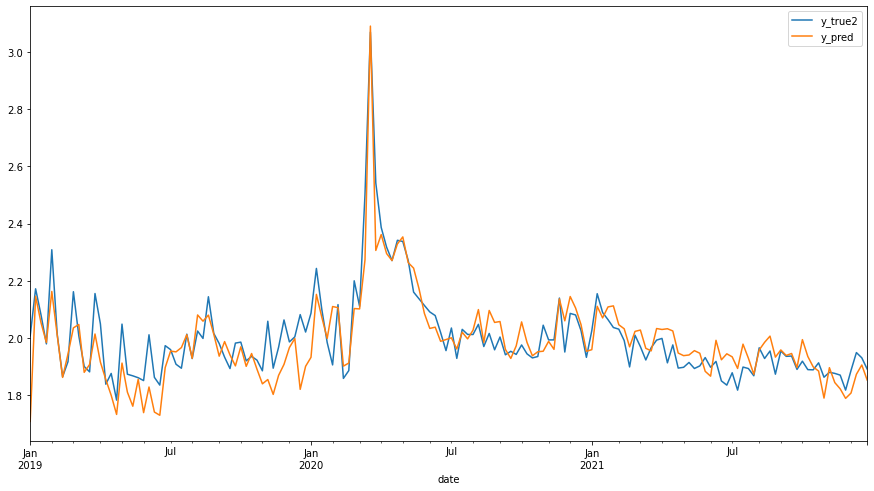

In [15]:
hf.show_prediction(media_model.factor_df, 
                   os.path.join(cfg.DATA_PATH, cfg.IMAGE_DUMP_PATH, 'media_prediction.png'), 
                   col_true='y_true2', col_pred='y_pred')

In [16]:
hf.get_metrics(media_model.factor_df, col_true = 'y_true2', col_pred = 'y_pred')

,year,mape,FA,rsq
0,2019,0.035401,0.964599,0.071900
1,2020,0.023149,0.976851,0.874100
2,2021,0.023297,0.976703,0.391790
3,total,0.027283,0.972717,0.755413


In [17]:
media_model.fit_summary.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[23],0.494,0.214,0.072,0.855,0.014,0.010,320.0,1359.0,1.03
alpha[1],3.085,1.497,1.000,5.740,0.053,0.037,357.0,1497.0,1.03
alpha[17],2.701,1.738,0.109,5.614,0.080,0.056,321.0,1024.0,1.03
gamma[13],0.471,0.207,0.138,0.891,0.016,0.014,347.0,595.0,1.03
peak[5],0.996,0.096,0.803,1.176,0.004,0.003,532.0,991.0,1.03
...,...,...,...,...,...,...,...,...,...
decay[22],0.435,0.219,0.084,0.785,0.045,0.032,23.0,20.0,1.28
decay[4],0.537,0.226,0.193,0.922,0.050,0.042,21.0,26.0,1.29
alpha[7],3.511,2.448,0.616,8.725,0.674,0.544,21.0,26.0,1.29
beta[17],0.229,0.417,0.000,1.308,0.144,0.108,20.0,14.0,1.34


In [18]:
hf.pickle_dump(os.path.join(cfg.DATA_PATH, cfg.MODEL_DUMP_PATH), 'media_model.pickle', 
               media_model.mmm_model)
hf.json_dump(os.path.join(cfg.DATA_PATH, cfg.INTER_PATH), "media_model_fit_result.json", 
             media_model.fit_result)
media_model.fit_summary.to_csv(
    os.path.join(cfg.DATA_PATH, cfg.INTER_PATH, 'media_model_fit_summary.csv'))
hf.pickle_dump(os.path.join(cfg.DATA_PATH, cfg.MODEL_DUMP_PATH), 'media_trace_loo.pickle', 
               media_model.loo)
hf.pickle_dump(os.path.join(cfg.DATA_PATH, cfg.MODEL_DUMP_PATH), 'media_waic_loo.pickle', 
               media_model.waic)

In [19]:
# upload_to_bucket(GCP_ID + '/model_artefacts/media_model.pickle', getcwd() + MODEL_DUMP_PATH + 'media_model.pickle',
#                  bucket_name)
# upload_to_bucket(GCP_ID + '/intermediate_files/media_model_fit_result.json',
#                  getcwd() + INTER_PATH + 'media_model_fit_result.json', bucket_name)
# upload_to_bucket(GCP_ID + '/intermediate_files/media_model_fit_summary.csv',
#                  getcwd() + INTER_PATH + 'media_model_fit_summary.csv', bucket_name)
# upload_to_bucket(GCP_ID + '/model_artefacts/media_trace_loo.pickle',
#                  getcwd() + MODEL_DUMP_PATH + 'media_trace_loo.pickle', bucket_name)
# upload_to_bucket(GCP_ID + '/model_artefacts/media_waic_loo.pickle',
#                  getcwd() + MODEL_DUMP_PATH + 'media_waic_loo.pickle', bucket_name)
# upload_to_bucket(GCP_ID + '/charts/media_prediction.png', getcwd() + IMAGE_DUMP_PATH + 'media_prediction.png',
#                  bucket_name)

# Reloop model

In [20]:
logging.info('Relooping Media Model!')

df = media_model.df.copy()
mdip_cols = media_model.mdip_cols
adstock_params = media_model.mmm['adstock_params'].copy()
adstk_df = get_adstk_sat_df(media_model)
sp_df = get_spend_df(media_model, get_avg_price_df)
sp_roi_df = get_roi_spend_df_full(media_model, cfg.rois_dd, cfg.GM, get_avg_price_df)

In [21]:
betas_dict = get_betas_dict(media_model, cfg.rois_dd, cfg.GM, get_avg_price_df)

In [22]:
%%time
reloop_model = get_reloop_model(media_model, betas_dict)
fit_result_reloop, fit_summary_reloop = fit_model(reloop_model, n_samples=cfg.RELOOP_N_SAMPLES,
                                                  n_tune_samples=cfg.RELOOP_N_TUNE_SAMPLES)

fit_summary_reloop.to_csv(
    os.path.join(cfg.DATA_PATH, cfg.INTER_PATH, 'media_model_fit_summary_reloop.csv'))

Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, tau, beta_online_sales, beta_base_sales, beta_cin, beta_gtrends]


Sampling 8 chains for 50 tune and 2_500 draw iterations (400 + 20_000 draws total) took 92 seconds.
The acceptance probability does not match the target. It is 0.9666640627286986, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


CPU times: user 28.5 s, sys: 497 ms, total: 29 s
Wall time: 1min 55s


/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [23]:
fit_summary_reloop

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_online_sales,-0.019,0.008,-0.034,-0.003,0.000,0.0,21733.0,13535.0,1.0
tau,-0.220,0.036,-0.288,-0.153,0.000,0.0,7759.0,9915.0,1.0
beta_gtrends,0.035,0.029,0.000,0.089,0.001,0.0,2157.0,2131.0,1.0
beta_cin,0.050,0.016,0.020,0.081,0.000,0.0,5127.0,3560.0,1.0
beta_base_sales,1.104,0.049,1.012,1.197,0.000,0.0,11636.0,10556.0,1.0
noise_var,0.001,0.000,0.001,0.002,0.000,0.0,19014.0,12436.0,1.0


In [24]:
mc_df = rebuild_mc_df(media_model, betas_dict, fit_result_reloop)  # rebuild the media contribution df
sanity_check(mc_df, sp_df, cfg.rois_dd, cfg.GM)
res_non_med = get_non_media_contribution(media_model, betas_dict, fit_result_reloop, df_ctrl, post_pred_control)
output_roi_df = get_output_roi_df(mc_df, sp_df, cfg.GM)
output_cont_df = get_final_contribution_output(media_model, mc_df, res_non_med)

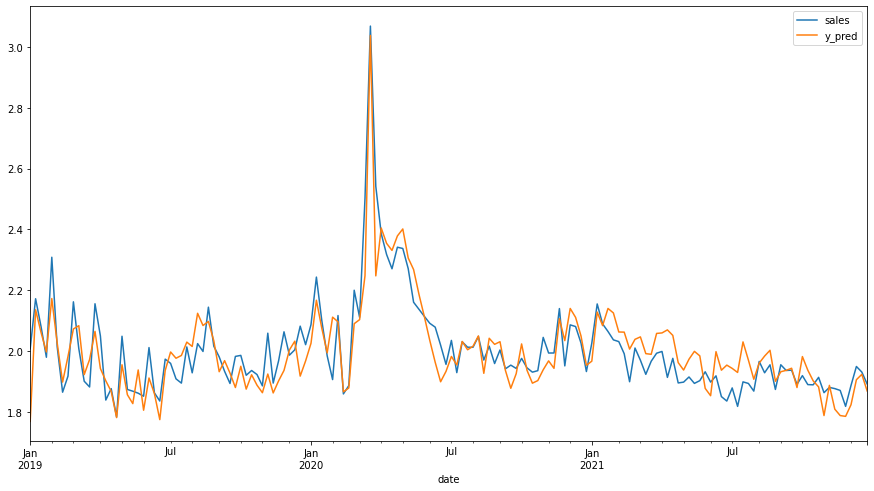

In [25]:
# Show predictions before rescaling
hf.show_prediction(rebuild_factor_df(media_model, betas_dict, fit_result_reloop),
                   os.path.join(cfg.DATA_PATH, cfg.IMAGE_DUMP_PATH, 
                                'reloop_prediction_before_rescaling.png'),
                   col_true = 'sales', col_pred = 'y_pred')

In [26]:
hf.get_metrics(rebuild_factor_df(media_model, betas_dict, fit_result_reloop), 
               col_true = 'sales', col_pred = 'y_pred')

,year,mape,FA,rsq
0,2019,0.030064,0.969936,0.440655
1,2020,0.024499,0.975501,0.850937
2,2021,0.029155,0.970845,0.032107
3,total,0.027906,0.972094,0.771869


In [27]:
sp_df.to_csv(os.path.join(cfg.DATA_PATH, cfg.INTER_PATH, 'sp_df.csv'))
mc_df.to_csv(os.path.join(cfg.DATA_PATH, cfg.INTER_PATH, 'mc_df.csv'))
res_non_med.to_csv(os.path.join(cfg.DATA_PATH, cfg.INTER_PATH, 'res_non_med.csv'))
output_roi_df.to_csv(os.path.join(cfg.DATA_PATH, cfg.INTER_PATH, 'output_roi_df.csv'))
output_cont_df.to_csv(os.path.join(cfg.DATA_PATH, cfg.INTER_PATH, 'output_cont_df.csv'))

# upload_to_bucket(GCP_ID + '/intermediate_files/sp_df.csv', getcwd() + INTER_PATH + 'sp_df.csv', bucket_name)
# upload_to_bucket(GCP_ID + '/intermediate_files/mc_df.csv', getcwd() + INTER_PATH + 'mc_df.csv', bucket_name)
# upload_to_bucket(GCP_ID + '/intermediate_files/res_non_med.csv', getcwd() + INTER_PATH + 'res_non_med.csv',
#                  bucket_name)
# upload_to_bucket(GCP_ID + '/intermediate_files/output_roi_df.csv', getcwd() + INTER_PATH + 'output_roi_df.csv',
#                  bucket_name)
# upload_to_bucket(GCP_ID + '/intermediate_files/output_cont_df.csv', getcwd() + INTER_PATH + 'output_cont_df.csv',
#                  bucket_name)

# Saturation models

media_metrics_mc_df
     year      mape        FA       rsq
0   2019  0.026286  0.973714  0.888707
1   2020  0.022165  0.977835  0.965899
2   2021  0.028854  0.971146  0.777377
3  total  0.025768  0.974232  0.950115
Compution for channel: amb


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.lo

Compution for channel: amzdsp


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return

Compution for channel: amzsearch


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Compution for channel: ctv


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return

Compution for channel: fb


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Compution for channel: fep


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return

Compution for channel: fluency


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return

Compution for channel: gads


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return

Compution for channel: hearst


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return

Compution for channel: insta


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Compution for channel: microads


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Compution for channel: oathvrzn


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return

Compution for channel: pin


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Compution for channel: pnda


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return

Compution for channel: tgtdsp


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return

Compution for channel: tgtsearch


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return

Compution for channel: tiktok


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.lo

Compution for channel: tv


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Compution for channel: webmd


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Compution for channel: wmdsp


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return

Compution for channel: wmsearch


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Compution for channel: yt


Multiprocess sampling (8 chains in 4 jobs)
NUTS: [noise_var, beta]


Sampling 8 chains for 500 tune and 2_500 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hakon/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return

Index(['fb', 'hearst', 'tiktok', 'insta', 'amb', 'oathvrzn', 'yt', 'tv',
       'amzsearch', 'pnda', 'wmsearch', 'tgtsearch', 'pin', 'fluency', 'ctv',
       'fep'],
      dtype='object')
CPU times: user 7min 12s, sys: 9.57 s, total: 7min 22s
Wall time: 7min 49s


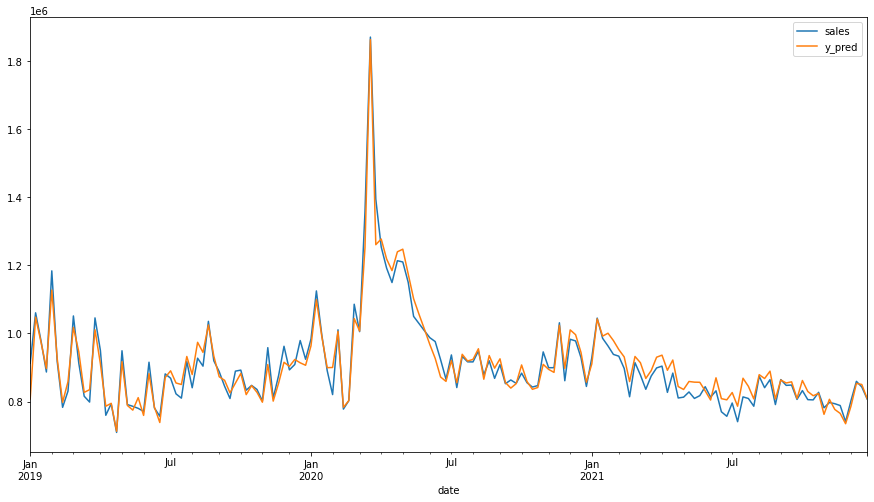

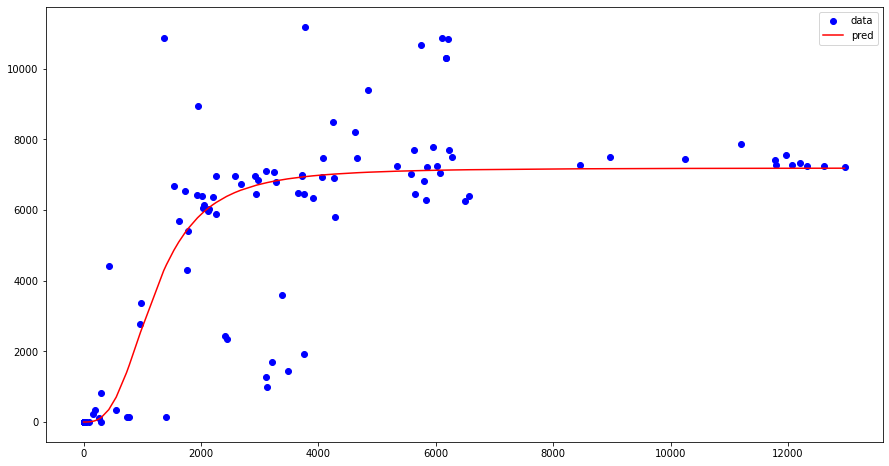

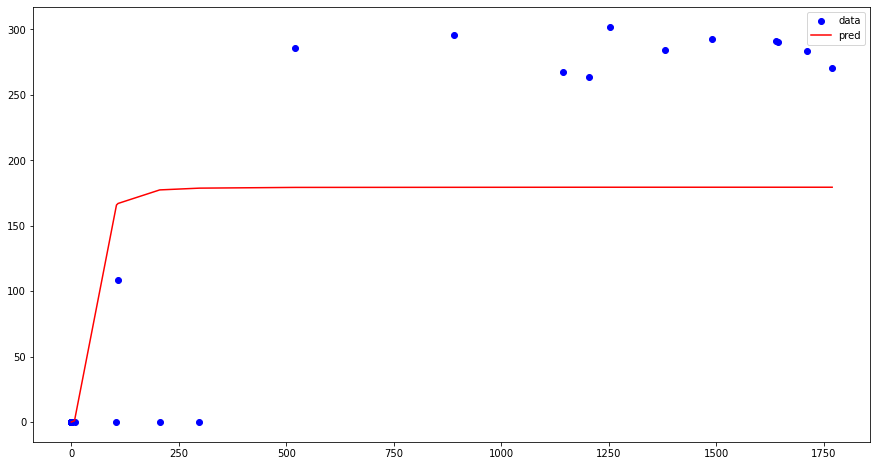

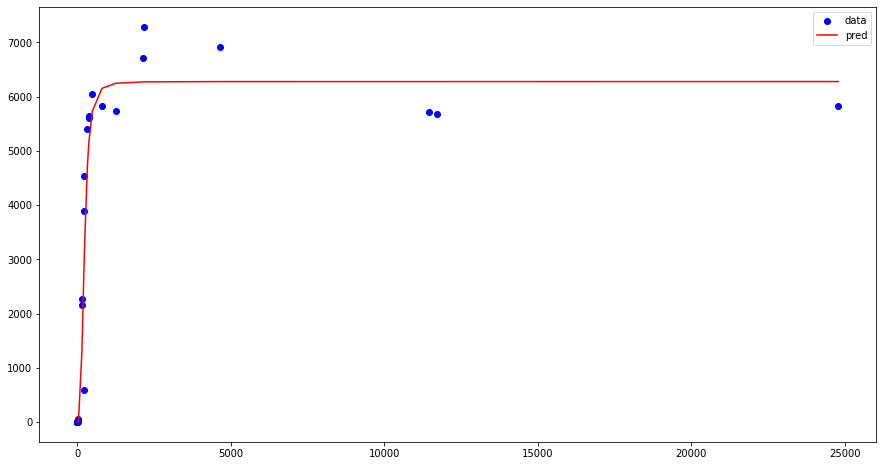

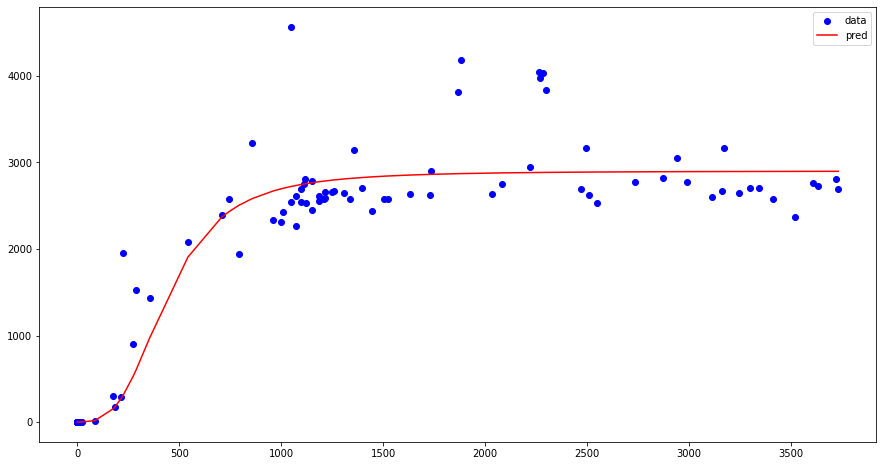

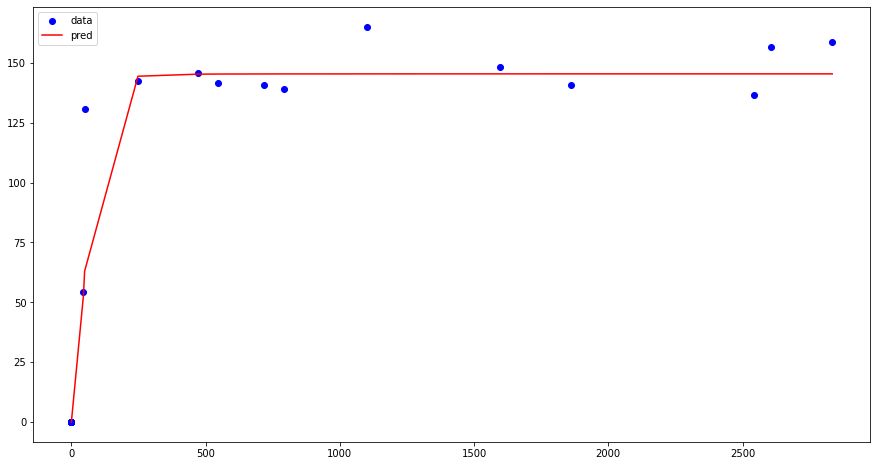

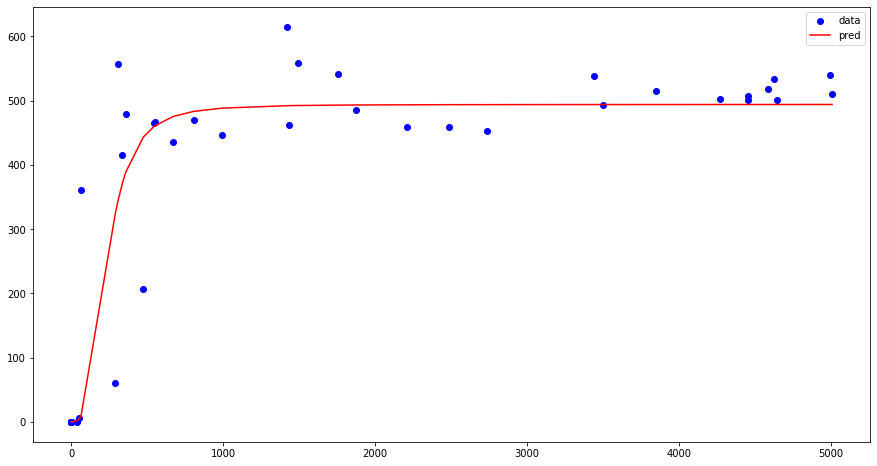

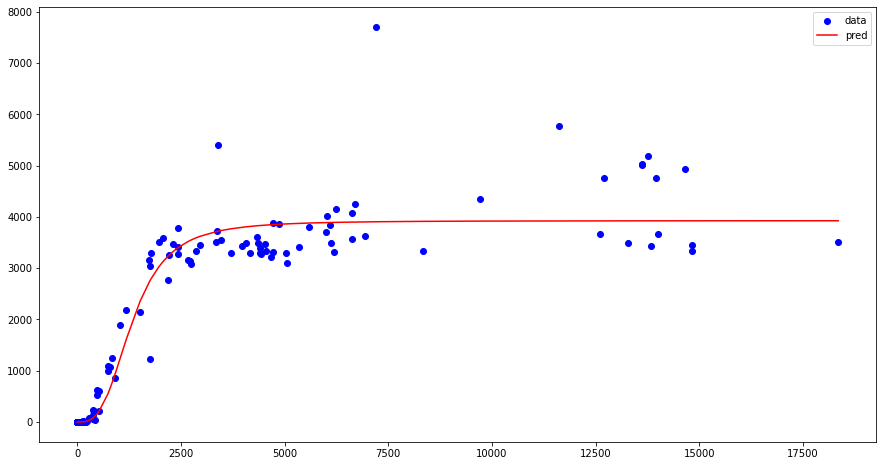

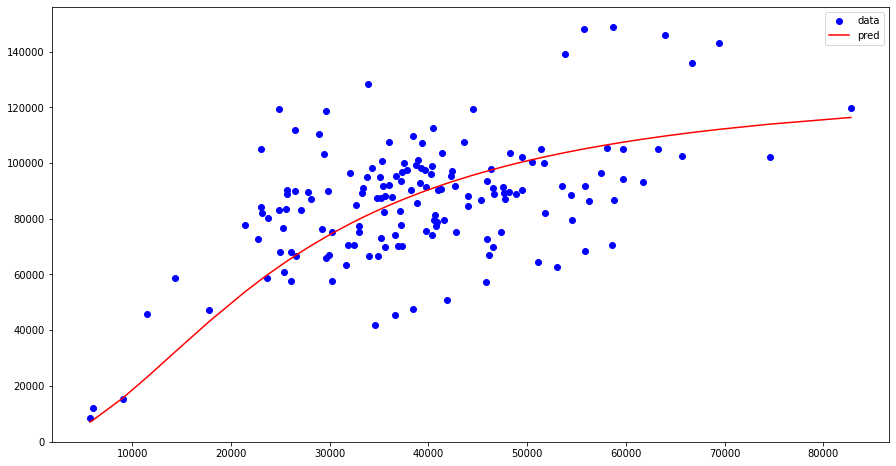

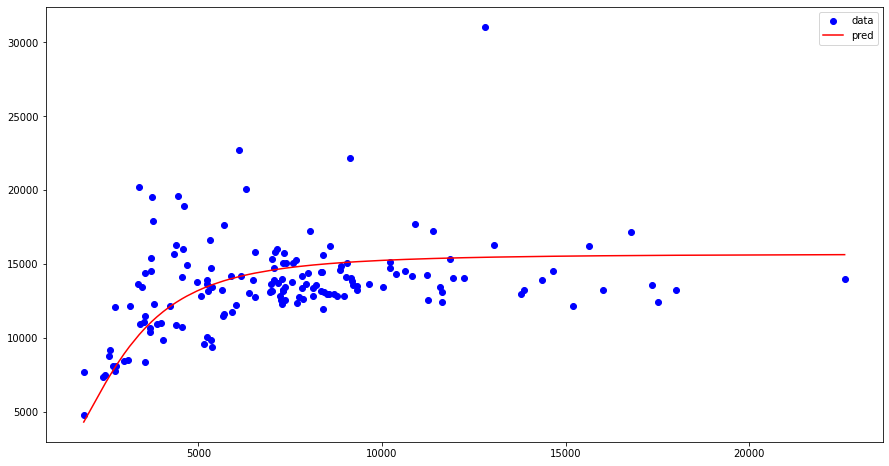

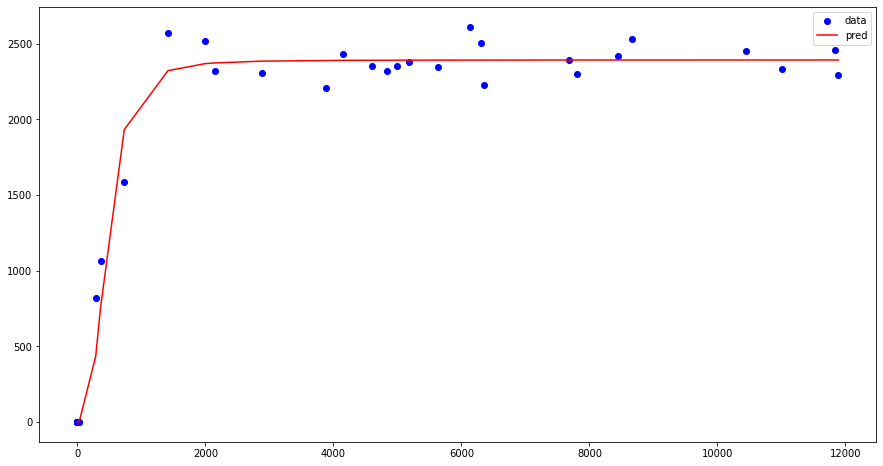

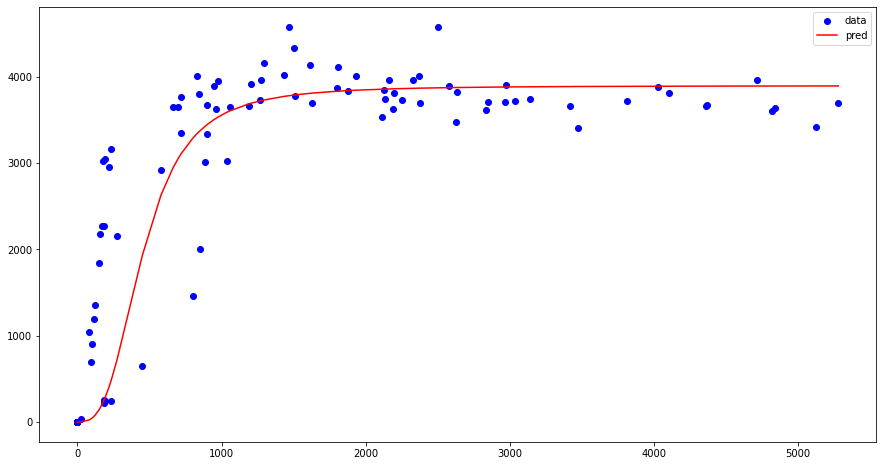

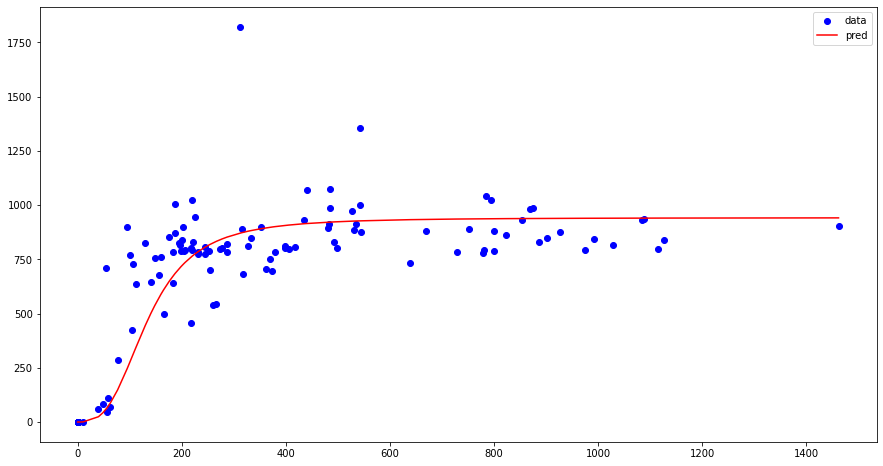

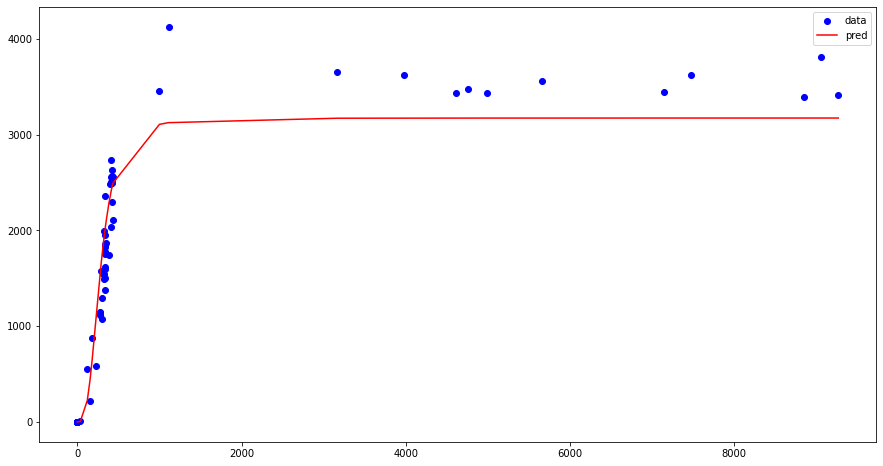

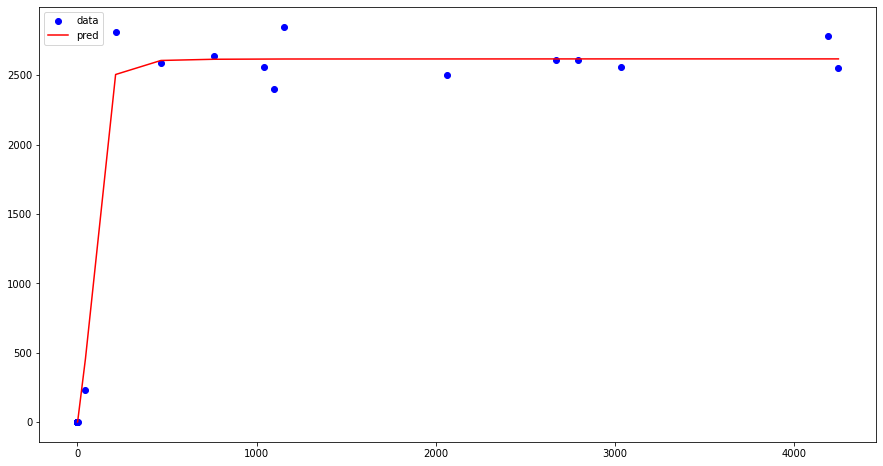

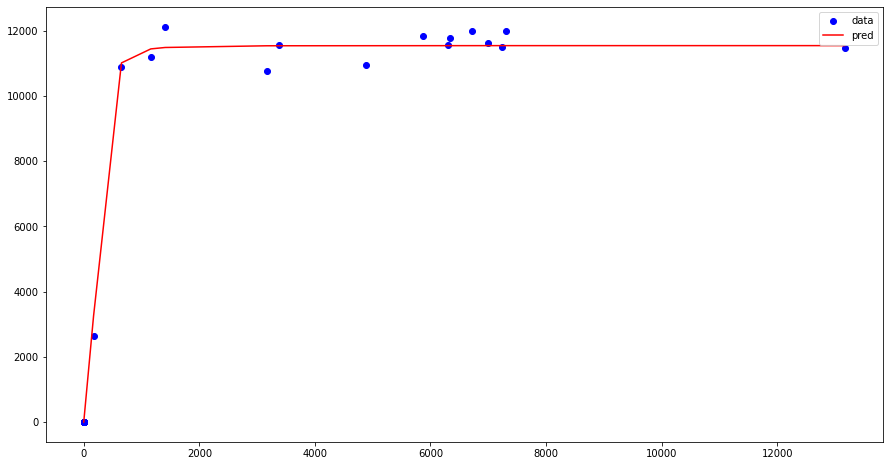

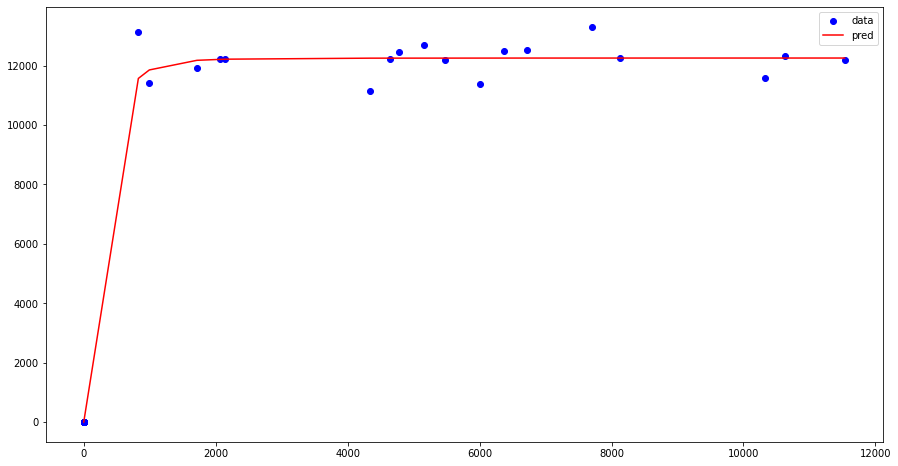

In [28]:
%%time
mc_df_rescaled = mc_df[['sales']].copy()
mc_df_rescaled['y_pred'] = mc_df.drop(columns=['sales']).sum(axis=1)
media_metrics_mc_df = hf.get_metrics(mc_df_rescaled, col_true='sales', col_pred='y_pred')
print('media_metrics_mc_df\n', media_metrics_mc_df)

hf.show_prediction(mc_df_rescaled, os.path.join(cfg.DATA_PATH, cfg.IMAGE_DUMP_PATH, 
                                                'media_prediction_rescaled.png'), 
                   col_true='sales',col_pred='y_pred')

logging.info('Building Saturation curves!')

sat_model = SaturationCurves(media_model, mc_df, get_avg_price_df)
sp_df.columns = sp_df.columns.str.replace(r'mdsp_', '')
channel = sat_model.ms_df[cfg.channel_cols].columns
print(channel)
for col in channel:
    show_saturation(sat_model, os.path.join(cfg.DATA_PATH, cfg.IMAGE_DUMP_PATH, f'sat_{col}.png'), 
                    sp_df, col)
    # upload_to_bucket(GCP_ID + '/charts/sat_' + col + '.png', getcwd() + IMAGE_DUMP_PATH + 'sat_' + col + '.png',
    #                  bucket_name)

In [29]:
df_beta_ctrl = get_beta_ctrl_df(df, post_pred_control)
df_beta_ctrl.to_csv(cfg.PATH_CTRL_MODEL_BETAS)

df_media_params = get_media_parameters(media_model)
df_media_params.to_csv(cfg.PATH_MEDIA_MODEL_PARAMS)

df_media_betas = get_beta_media_model(betas_dict, fit_result_reloop)
df_media_betas.to_csv(cfg.PATH_MEDIA_MODEL_BETAS)

df_sat_params = get_saturation_model_params(sat_model)
df_sat_params.to_csv(cfg.PATH_SAT_MODEL_PARAMS)

In [31]:
# Media model betas
df_beta_media = pd.read_csv(cfg.PATH_MEDIA_MODEL_BETAS)

# Media model params
df_params_media = pd.read_csv(cfg.PATH_MEDIA_MODEL_PARAMS)

# Data dump

In [32]:
rebuild_results.save_rois_csv('./data/final_files/BM_ROI_prior_df.csv')

In [33]:
rebuild_results.save_input_df(df, media_model.mdip_cols, media_model.mdsp_cols, 
                              cfg.PATH_MAIN_FULL)

In [34]:
# average_price_df
rebuild_results.save_average_price('./data/final_files/BM_average_price_df.csv')

In [35]:
rebuild_results.save_mc_df('./data/final_files/BM_mc_df.csv')

In [36]:
rebuild_results.save_factor_df('./data/final_files/BM_factor_df.csv')

# Prepare data for redistribution pipeline

In [ ]:
rebuild_results.save_halo_df(cfg.PATH_TOTAL_SUB_BRAND_SPEND)

In [37]:
rebuild_results.save_mc_df_with_cannib('./data/intermediate_files/BM_mc_df_with_cannib.csv')

In [113]:
for SB in cfg.FINISH_SUB_BRANDS:
    rebuild_results.save_sub_brand_df('b&m', SB, cfg.PATH_MAIN_SB)

In [114]:
for SB in cfg.FINISH_SUB_BRANDS:
    rebuild_results.save_sub_brand_df('b&m', SB, cfg.PATH_AVG_PRICE_SB)